# Visualizing the word2vec embeddings

In this example, we'll train a word2vec model using Gensim and then, we'll visualize the embedding vectors using the `sklearn` implementation of [t-SNE](https://lvdmaaten.github.io/tsne/). t-SNE is a dimensionality reduction technique, which will help us visualize the multi-dimensional embedding vectors over a 2D Plot.

Let's start with the imports:

In [1]:
import logging
import pprint  # beautify prints

import gensim.downloader as gensim_downloader
import matplotlib.pyplot as plt
import numpy as np
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE

logging.basicConfig(level=logging.INFO)

Next, let's instantiate and train Gensim's word2vec model using the `text8` dataset. `text8` is embedded in Gensim and contains the tokenized version of the first 100mB of Wikipedia:

In [2]:
model = Word2Vec(
    sentences=gensim_downloader.load('text8'),  # download and load the text8 dataset
    sg=0, size=100, window=5, negative=5, min_count=5, iter=5)

INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:collected 253854 word types from a corpus of 17005207 raw words and 1701 sentences
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:effective_min_count=5 retains 71290 unique words (28% of original 253854, drops 182564)
INFO:gensim.models.word2vec:effective_min_count=5 leaves 16718844 word corpus (98% of original 17005207, drops 286363)
INFO:gensim.models.word2vec:deleting the raw counts dictionary of 253854 items
INFO:gensim.models.word2vec:sample=0.001 downsamples 38 most-common words
INFO:gensim.models.word2vec:downsampling leaves estimated 12506280 word corpus (74.8% of prior 16718844)
INFO:gensim.models.base_any2vec:estimated required memory for 71290 words and 100 dimensions: 92677000 bytes
INFO:gensim.models.word2vec:resetting layer weights
INFO:gensim.models.b

INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 23.57% examples, 733233 words/s, in_qsize 6, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 29.45% examples, 734405 words/s, in_qsize 5, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 35.27% examples, 734472 words/s, in_qsize 5, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 41.15% examples, 734749 words/s, in_qsize 4, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 46.62% examples, 727076 words/s, in_qsize 6, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 52.26% examples, 724129 words/s, in_qsize 5, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 57.85% examples, 721456 words/s, in_qsize 4, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 63.43% examples, 719112 words/s, in_qsize 5, out_qsize 0
INFO:gensim.models.base_any2vec:EPOCH 4 - PROGRESS: at 69.02% examples, 716350 words/s, in_qsize 4, out_

Let's see the results of the training by showing the most similar words to the combination of `woman` and `king`:

In [3]:
pprint.pprint(model.wv.most_similar(positive=['woman', 'king'], negative=['man']))

INFO:gensim.models.keyedvectors:precomputing L2-norms of word weight vectors


[('queen', 0.6840947866439819),
 ('elizabeth', 0.6495713591575623),
 ('empress', 0.636602520942688),
 ('prince', 0.6254769563674927),
 ('princess', 0.6251226663589478),
 ('emperor', 0.6248080730438232),
 ('throne', 0.6207752227783203),
 ('isabella', 0.5928826332092285),
 ('son', 0.5875461101531982),
 ('regent', 0.5874534845352173)]


We can see that the model has been trained properly, because the most similar words are quite relevant to the input query.

Next, we'll continue with the t-SNE visualization. To do this, we'll collect the words (and vectors), most similar to the set of seed words below. Each seed word will serve as the core of a `embedding_groups` of it's most similar words:

In [4]:
target_words = ['mother', 'car', 'tree', 'science', 'building', 'elephant', 'green']
word_groups, embedding_groups = list(), list()

for word in target_words:
    words = [w for w, _ in model.wv.most_similar(word, topn=5)]
    word_groups.append(words)

    embedding_groups.append([model.wv[w] for w in words])

Next, we'll use the `embedding_groups` to train the t-SNE model for 5000 iterations:

In [5]:
embedding_groups = np.array(embedding_groups)
m, n, vector_size = embedding_groups.shape
tsne_model_en_2d = TSNE(perplexity=8, n_components=2, init='pca', n_iter=5000)

Next, we'll use the model to generate embeddings reduced to only 2 dimensions:

In [6]:
embeddings_2d = tsne_model_en_2d.fit_transform(embedding_groups.reshape(m * n, vector_size))
embeddings_2d = np.array(embeddings_2d).reshape(m, n, 2)

Finally, we'll visualize the generated embeddings:

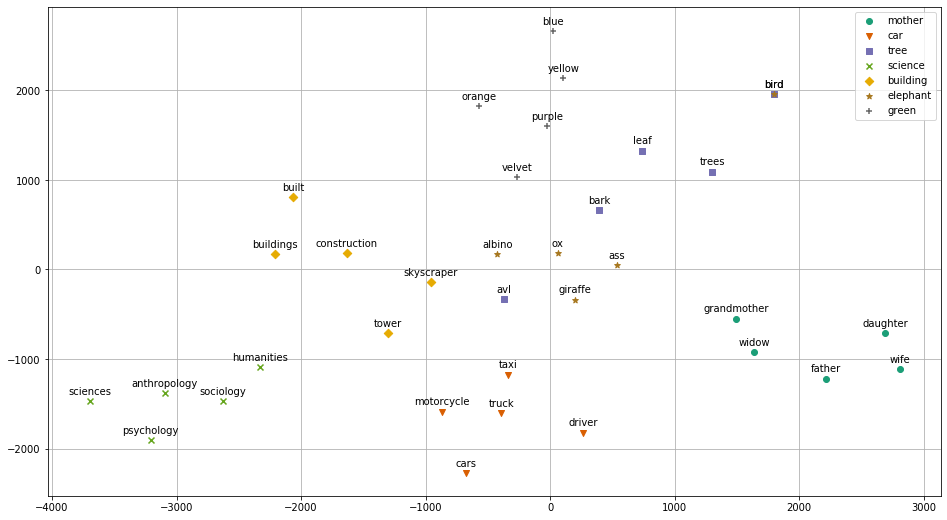

In [7]:
# Plot the results
plt.figure(figsize=(16, 9))
# Different color and marker for each group of similar words
color_map = plt.get_cmap('Dark2')(np.linspace(0, 1, len(target_words)))
markers = ['o', 'v', 's', 'x', 'D', '*', '+']

# Iterate over all groups
for label, similar_words, emb, color, marker in \
        zip(target_words, word_groups, embeddings_2d, color_map, markers):
    x, y = emb[:, 0], emb[:, 1]

    # Plot the points of each word group
    plt.scatter(x=x, y=y, c=[color], label=label, marker=marker)

    # Annotate each vector with it's corresponding word
    for word, w_x, w_y in zip(similar_words, x, y):
        plt.annotate(word, xy=(w_x, w_y), xytext=(0, 15),
                     textcoords='offset points', ha='center', va='top', size=10)
plt.legend()
plt.grid(True)
plt.show()